# This Part Works 


## SubgraphX on BA-Shapes dataset for 2-layer GCN

In [1]:
import os
import os.path as osp

import torch
from torch_geometric.data import download_url, extract_zip

from digg.xgraph.dataset import SynGraphDataset
from digg.xgraph.models import *
from digg.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [3]:
dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

/Users/beatrixwen/miniforge3/envs/py_ten/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Load model and checkpoints

In [4]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)


model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
from digg.xgraph.method import SubgraphX

explainer = SubgraphX(model, num_classes=4, device=device,
                      explain_graph=False, reward_method='nc_mc_l_shapley')

### Visualization

explain graph node 515


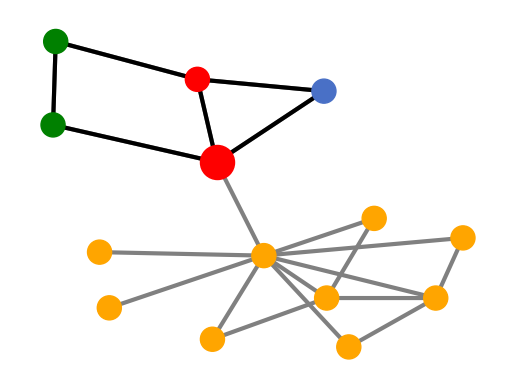

In [6]:
# --- Create data collector and explanation processor ---
from digg.xgraph.evaluation import XCollector

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

from digg.xgraph.method.subgraphx import PlotUtils
from digg.xgraph.method.subgraphx import find_closest_node_result

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

### The metric result

In [8]:
max_nodes = 5
for node_idx in node_indices:
    index += 1
    print(f'explain graph node {node_idx}')
    data.to(device)

    if torch.isnan(data.y[0].squeeze()):
        continue

    logits = model(data.x, data.edge_index)
    prediction = logits[node_idx].argmax(-1).item()

    _, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

    explanation_results = explanation_results[prediction]
    explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)
    result = find_closest_node_result(explanation_results, max_nodes=max_nodes)

    x_collector.collect_data(result.coalition, related_preds, label=prediction)
    if index >= 20:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n',
      f'Infidelity: {x_collector.fidelity_inv:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

explain graph node 302
explain graph node 313
explain graph node 321
explain graph node 332
explain graph node 336
explain graph node 348
explain graph node 356
explain graph node 367
explain graph node 369
explain graph node 381
explain graph node 387
explain graph node 418
explain graph node 454
explain graph node 461
explain graph node 466
explain graph node 469
explain graph node 471
explain graph node 497
explain graph node 508
explain graph node 514
explain graph node 515
Fidelity: 0.7987
 Infidelity: 0.2364
Sparsity: 0.1818


# Newly Added Parts

In [1]:
import os
import os.path as osp

import torch
from torch_geometric.data import download_url, extract_zip

from digg.xgraph.dataset import SynGraphDataset, MoleculeDataset
from digg.xgraph.models import *
from digg.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
# dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset = MoleculeDataset('./datasets', 'MUTAG')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

/Users/beatrixwen/miniforge3/envs/py_ten/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Load model and checkpoints

In [3]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)




In [4]:
model = GCN_2l(model_level='graph', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)



GCN_2l(
  (conv1): GCNConv(1, 300)
  (convs): ModuleList(
    (0): GCNConv(300, 300)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): GlobalMeanPool()
  (ffn): Sequential(
    (0): Linear(in_features=300, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

/Users/beatrixwen/Downloads/DIG/benchmarks/xgraph/train_gnns.py

check_checkpoints()
ckpt_path = osp.join('checkpoints', 'mutag_ckpt', 'gcn_best.pth')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['net'])
model.load_state_dict(state_dict)

In [5]:
from digg.xgraph.method import SubgraphX

explainer = SubgraphX(model, num_classes=4, device=device,
                      explain_graph=True, reward_method='mc_l_shapley')

### Visualization

In [17]:
data.y

tensor([1])

In [19]:
from digg.xgraph.method.subgraphx import PlotUtils
from digg.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
subgraph_x, subgraph_edge_index, subset, edge_mask, kwargs = \
    MCTS.__subgraph__(node_idx, data.x, data.edge_index, num_hops=2)
# subgraph_y = data.y[subset].to('cpu')
subgraph_y = data.y
# new_node_idx = torch.argwhere(subset == node_idx)[0]

vis_graph = to_networkx(Data(x=subgraph_x, edge_index=subgraph_edge_index))
plotutils = PlotUtils(dataset_name='mutag')
# plotutils.plot(vis_graph, nodelist=[], figname=None, y=subgraph_y, node_idx=new_node_idx)
plotutils.plot(vis_graph, nodelist=subgraph_x, figname=None, y=subgraph_y)

AttributeError: 'NoneType' object has no attribute 'cpu'

In [6]:
# --- Create data collector and explanation processor ---
from digg.xgraph.evaluation import XCollector

x_collector = XCollector()

index = -1
# node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
node_indices = None
data = dataset[0]

from digg.xgraph.method.subgraphx import PlotUtils
from digg.xgraph.method.subgraphx import find_closest_node_result

# Visualization
max_nodes = 2
# node_idx = node_indices[20]
node_idx=None
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()



explain graph node None


In [10]:
prediction,data.y

(1, tensor([1]))

[tensor(-0.0087)]
[tensor(-0.0087)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0082)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0087)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0082)]
[tensor(-0.0087)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0082)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0080)]
[tensor(-0.0082)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0

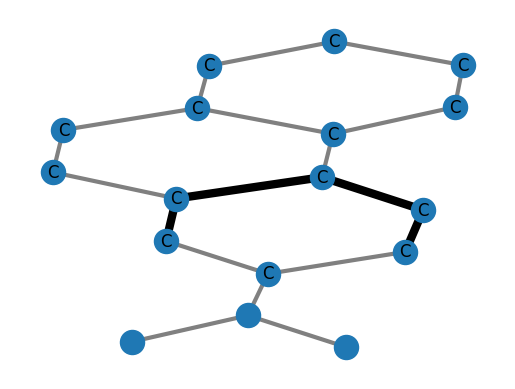

In [7]:
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

plotutils = PlotUtils(dataset_name='mutag', is_show=True)
explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

In [8]:
max_nodes = 5
for node_idx in node_indices:
    index += 1
    print(f'explain graph node {node_idx}')
    data.to(device)

    if torch.isnan(data.y[0].squeeze()):
        continue

    logits = model(data.x, data.edge_index)
    prediction = logits[node_idx].argmax(-1).item()

    _, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

    explanation_results = explanation_results[prediction]
    explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)
    result = find_closest_node_result(explanation_results, max_nodes=max_nodes)

    x_collector.collect_data(result.coalition, related_preds, label=prediction)
    if index >= 20:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n',
      f'Infidelity: {x_collector.fidelity_inv:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

TypeError: 'NoneType' object is not iterable

In [21]:
from digg.xgraph.method.subgraphx import find_closest_node_result
plotutils = PlotUtils(dataset_name='mutag')

# Visualization
max_nodes = 5
# node_idx = node_indices[20]
node_idx = None
_, explanation_results, related_preds = \
    explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
result = find_closest_node_result(explanation_results[prediction], max_nodes=max_nodes)
related_preds[prediction]

[tensor(-0.0087)]
[tensor(-0.0087)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0082)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0087)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0082)]
[tensor(-0.0087)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0082)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0080)]
[tensor(-0.0082)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0.0081)]
[tensor(-0

AttributeError: 'dict' object has no attribute 'coalition'